# Door-opening example (simplified)

This notebook is a cleaned, reproducible version of the CCDP door-opening experiment. It follows the same pipeline as the paper: synthesize demonstrations in MuJoCo, train diffusion models over key-frame trajectories, and sample handle-conditioned proposals (with optional avoidance). The training setup uses a fixed initial hand pose and predicts the full-horizon trajectory; during execution, the controller re-aligns to the closest phase on the predicted path instead of resetting to the initial state.

## What this notebook covers

- **Task**: open a cabinet door in MuJoCo using a floating hand model.
- **Conditioning signal**: the target handle position, plus optional failed attempts.
- **Actions**: joint-space key frames over a fixed horizon.
- **Door modes**: multiple hinge axes (lift, pull, push) labeled by `DoorConfig.slide_mode_labels`.

## Pipeline at a glance

1. **Configure the task** with `DoorConfig` (timing, dataset size, model paths).
2. **Load or synthesize demonstrations** and cache them for reuse.
3. **Inspect a demo** to verify geometry and the demonstration distribution.
4. **Normalize trajectories and build data loaders** for training.
5. **Train or load the unconditional diffusion model**, which learns a prior over trajectories.
6. **Train or load the state-conditioned diffusion model**, which conditions on the handle location.
7. **Sample candidate key frames** for debugging/inspection.
8. **Build an avoidance dataset** and train the avoidance model.
9. **Sample with avoidance** and evaluate the resulting door-opening mode.

## Data and models

- Demonstrations include end-effector pose, joint states, object states, and slide-mode labels.
- The diffusion models are `ConditionalUnet1D` networks; one unconditional, one conditioned on the handle position.
- Cached artifacts live in `models/` (see `DoorConfig` for filenames).

## Practical notes

- Use `preload_*` flags in `DoorConfig` to skip expensive steps (dataset generation and training).
- If you change the door geometry or hinge mode, regenerate demonstrations to keep conditioning consistent.
- The avoidance model uses `avoidance_distance_threshold` to steer new proposals away from recent failures.

## References

See `README.md` and the CCDP project page for broader context. This notebook corresponds to the door-opening task described in the paper.


In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import annotations

import mujoco
import numpy as np
import torch
import mediapy as media

from door_config import DoorConfig
from door_models import ConditionalUnet1D
from door_pipeline_clean import *

## Configure the training pipeline

This section defines the experiment configuration through `DoorConfig`. Typical edits include:

- **Data settings**: `n_demos`, random `seed`, and dataset caching flags.
- **Model settings**: diffusion steps, epochs, batch size, and checkpoint paths.
- **Avoidance settings**: dataset size, distance threshold, and pretrained usage.

Adjust these values to trade off runtime versus fidelity. When `preload_*` flags are enabled, the notebook will reuse cached datasets and checkpoints in `models/` instead of recomputing them.


In [2]:
cfg = DoorConfig(
    n_demos=2500,
    preload_dataset=True,
    preload_state_model=True,
    preload_uncond_model=True,
    avoidance_preload = True,
    avoidance_preload_model = True,
)

## Load or generate demonstrations

Demonstrations are synthesized in simulation using a simple, consistent heuristic:

1. Move the hand toward the handle while aligning a grasp-ready orientation.
2. Reach the grasp pose.
3. Close the gripper to grasp the handle.
4. Move in the desired opening direction (known during demonstration generation).

The resulting trajectories include end-effector pose, joint state, object state, and the slide-mode label. They are cached to disk (see `DoorConfig.dataset_cache_path`) so you can skip regeneration on future runs.


In [3]:
demos = load_or_generate_dataset(cfg, seed=cfg.seed)

Loading cached demos from /remote/idiap.svm/temp.rli01/afard/CCDP-main/models/door_demos_clean.pkl


/remote/idiap.svm/temp.rli01/afard/CCDP-main/Main Codes/door_pipeline_clean.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  payload = torch.load(path, map_location="cpu

### Visualizing the demos (debugging)

Rendering a single demonstration is a quick sanity check. Use this to verify the cabinet pose, handle position, and slide mode before training. If the geometry looks off, regenerate the dataset after fixing the XML or configuration.


In [4]:
frames =  visualize_demo(cfg, demos, demo_idx=2000)
media.show_video(images = frames, fps = cfg.framerate)

## Training

Here we normalize trajectories and build data loaders for two diffusion models:

- **Unconditional model**: learns a prior over door-opening trajectories.
- **State-conditioned model**: conditions on the handle position to target a specific door configuration.

Training uses the same architecture (`ConditionalUnet1D`) for both, with different conditioning dimensions.


In [5]:
action_norm, state_norm, uncond_loader, state_loader = build_dataloaders(cfg, demos)
print("action max:", action_norm._max.max())
print("state max:", state_norm._max.max())
print("action min:", action_norm._min.min())
print("state min:", state_norm._min.min())

action max: tensor(1.3823, device='cuda:0', dtype=torch.float64)
state max: tensor(1.3519, device='cuda:0', dtype=torch.float64)
action min: tensor(-0.2499, device='cuda:0', dtype=torch.float64)
state min: tensor(0.1222, device='cuda:0', dtype=torch.float64)


In [6]:
uncond_model = ConditionalUnet1D(input_dim=cfg.n_dof, global_cond_dim=0, diffusion_step_embed_dim=256)
if cfg.preload_uncond_model and cfg.uncond_ckpt_path.exists():
    load_model_if_available(uncond_model, cfg.uncond_ckpt_path, device=cfg.device)
else:
    train_diffusion_model(uncond_model, uncond_loader, cfg, conditioning=False, save_path=cfg.uncond_ckpt_path)

ConditionalUnet1D parameters: 6.521344e+07


/remote/idiap.svm/temp.rli01/afard/CCDP-main/Main Codes/door_pipeline_clean.py:1070: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_loc

Loaded weights from /remote/idiap.svm/temp.rli01/afard/CCDP-main/models/door_uncond_clean.pth


In [7]:
state_model = ConditionalUnet1D(input_dim=cfg.n_dof, global_cond_dim=demos.x_des.shape[1], diffusion_step_embed_dim=256)
if cfg.preload_state_model and cfg.state_ckpt_path.exists():
    load_model_if_available(state_model, cfg.state_ckpt_path, device=cfg.device)
else:
    train_diffusion_model(state_model, state_loader, cfg, conditioning=True, save_path=cfg.state_ckpt_path)

ConditionalUnet1D parameters: 6.525645e+07


Loaded weights from /remote/idiap.svm/temp.rli01/afard/CCDP-main/models/door_state_clean.pth


### Testing the combination of the state-conditioned and unconditional models

This cell samples candidate key frames by combining the unconditional prior with the handle-conditioned model. The visualization helps confirm that the generated trajectories are plausible and aligned with the desired handle location.


""

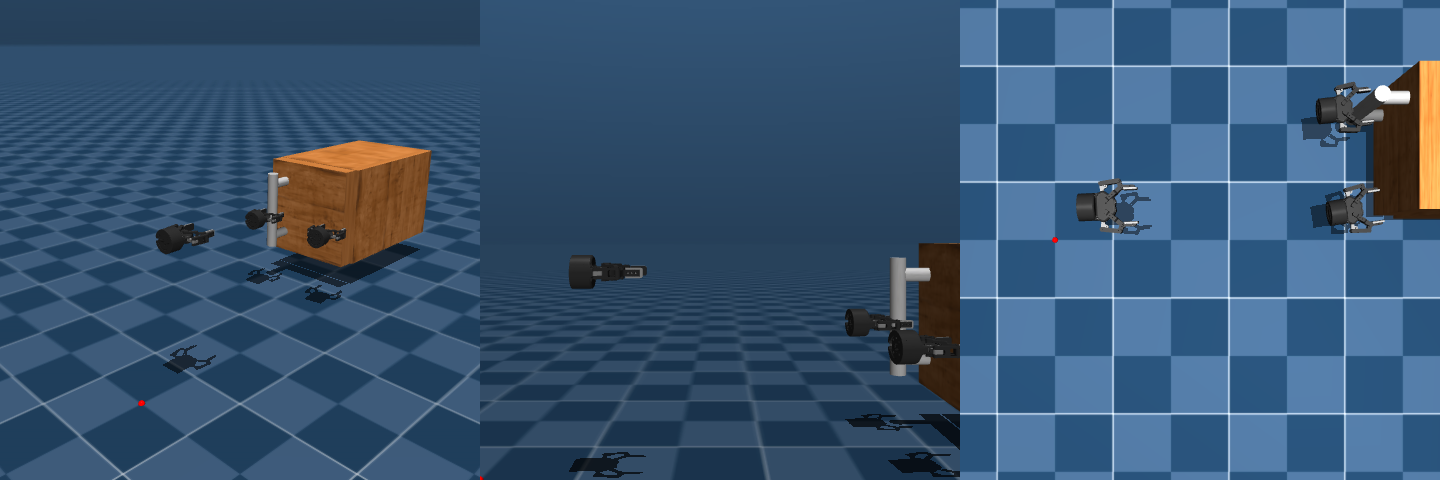

""

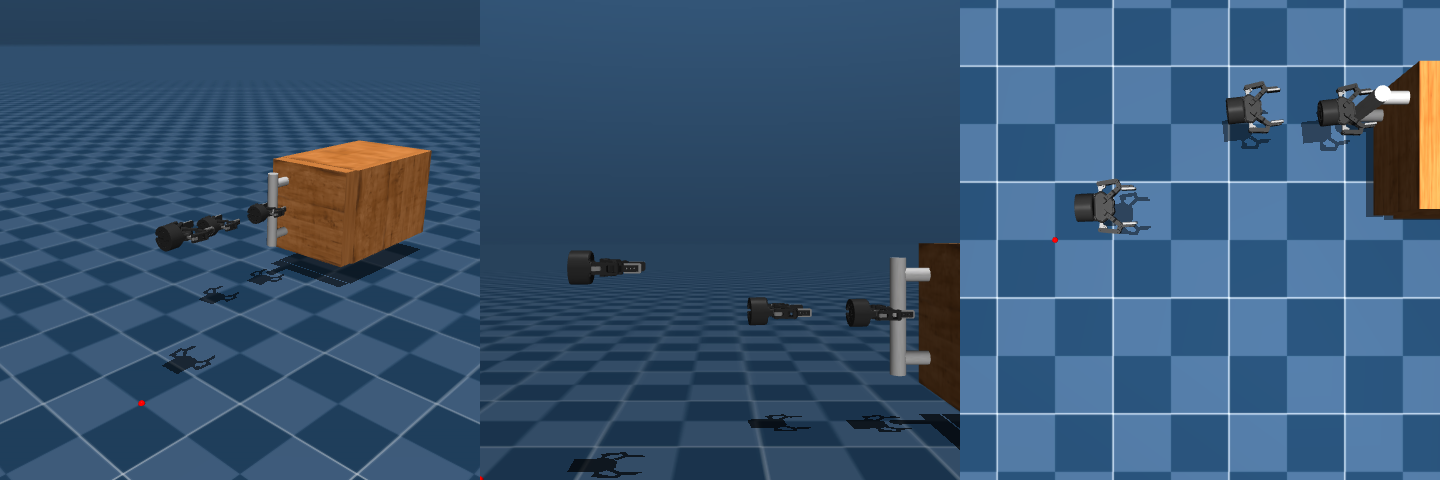

""

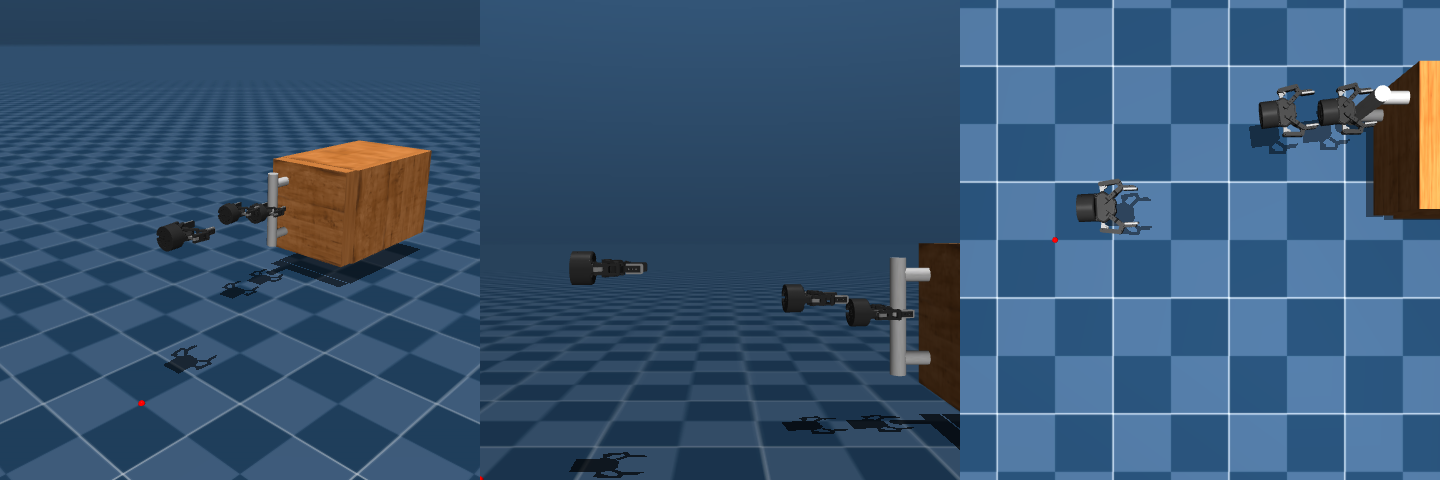

""

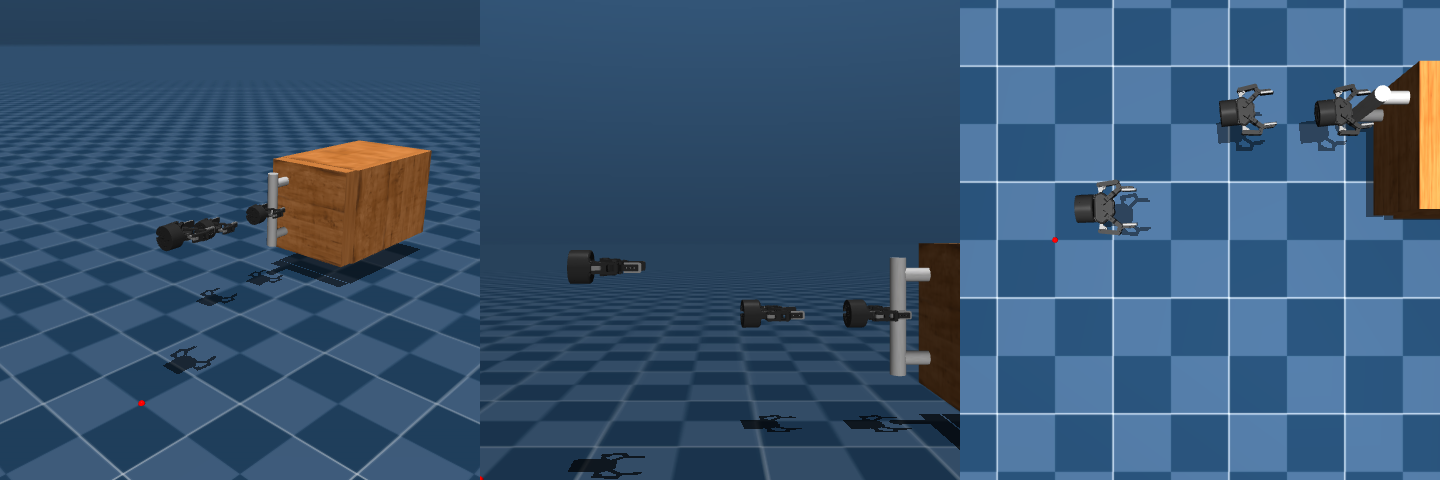

In [8]:
label_idx = 0
label = torch.from_numpy(demos.x_des[label_idx]).to(cfg.device)
samples = sample_conditioned(uncond_model, state_model, action_norm, state_norm, label, cfg, n_samples=4)

for i in range(samples.shape[0]):
    key_frames = samples[i,:,:].cpu().numpy()
    img = visualize_key_frames(cfg, demos.cabinet_pos[label_idx], key_frames)
    media.show_image(img)

### Avoidance models

To encourage diversity after failed attempts, we build an avoidance dataset and train a separate diffusion model that conditions on previously sampled trajectories. At inference time, this model biases new proposals away from recent failures.


In [9]:
avoidance_samples = load_or_generate_avoidance(cfg, uncond_model, state_model, action_norm, state_norm)

/remote/idiap.svm/temp.rli01/afard/CCDP-main/Main Codes/door_pipeline_clean.py:1049: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(cfg.avoidance_dataset_pa

Loaded avoidance dataset from /remote/idiap.svm/temp.rli01/afard/CCDP-main/models/door_samples_avoidance_ddpm.pt with shape (247784, 67)


In [10]:
avoidance_loader, label_dim = build_avoidance_dataloader(avoidance_samples, action_norm, state_norm, cfg)
avoidance_model = ConditionalUnet1D(input_dim=cfg.n_dof, global_cond_dim=label_dim, diffusion_step_embed_dim=256)
if cfg.avoidance_preload_model and cfg.avoidance_ckpt_path.exists():
    load_model_if_available(avoidance_model, cfg.avoidance_ckpt_path, cfg.device)
else:
    train_diffusion_model(avoidance_model, avoidance_loader, cfg, conditioning=True, save_path=cfg.avoidance_ckpt_path)


ConditionalUnet1D parameters: 6.571520e+07
Loaded weights from /remote/idiap.svm/temp.rli01/afard/CCDP-main/models/door_avoidance_clean.pth


## Evaluation

We use a lightweight diagnostic to infer the intended door-opening direction from the final end-effector position. This provides a quick check that sampled trajectories correspond to the expected slide mode before running a full rollout.


In [11]:
# An auxiliary function to identify which direction the robot intends to open the door. 
# It is calculated based on the final position of the end-effector after executing the trajectory.
def check_mode(rmodel_aux, rdata_aux, final_state):
    rdata_aux.qpos[:4] = final_state
    mujoco.mj_forward(rmodel_aux, rdata_aux)
    cur_pos_final  = (rdata_aux.body('right_silicone_pad').xpos + rdata_aux.body('left_silicone_pad').xpos)/2
    diff_move = cur_pos_final - rdata_aux.geom("door_handle").xpos.copy()
    max_arg_move = np.argmax(abs(diff_move))
    mode = -1
    if max_arg_move == 0:
        mode = 1
    elif max_arg_move == 1:
        if diff_move[1]>0:
            mode = 3
        elif diff_move[1]<0:
            mode = 2
    elif max_arg_move == 2:
        mode = 0
    return mode

### Variation test

Each sampling round conditions on previously selected trajectories. The goal is to increase the chance of discovering different modes across successive attempts by discouraging repeats.


desired mode: 1


""

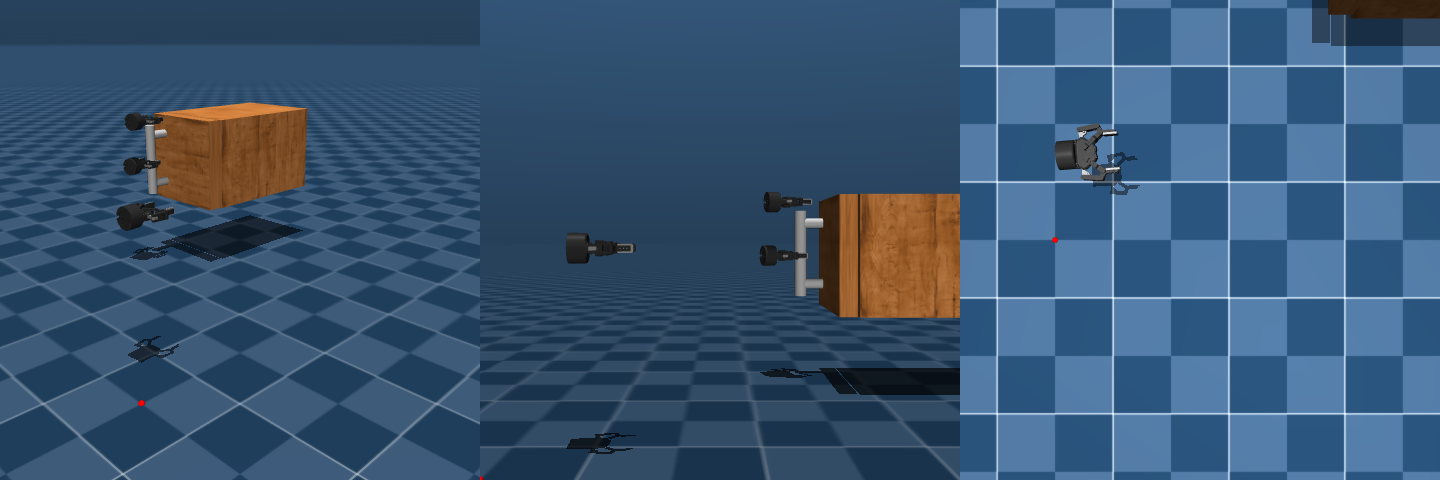

Trying mode: 0


""

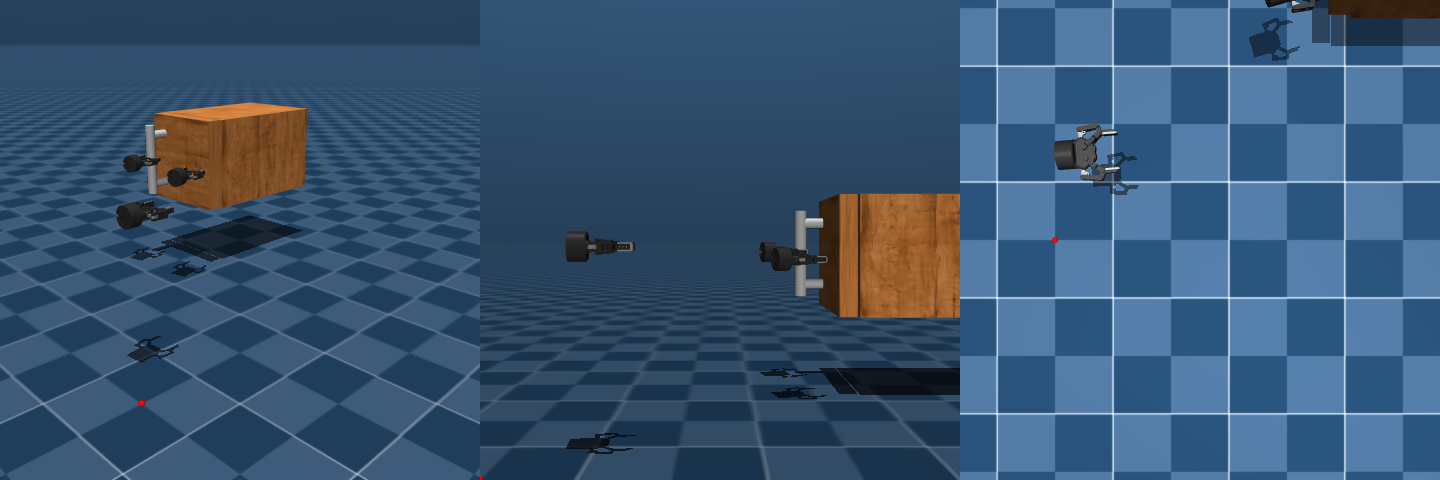

Trying mode: 2


""

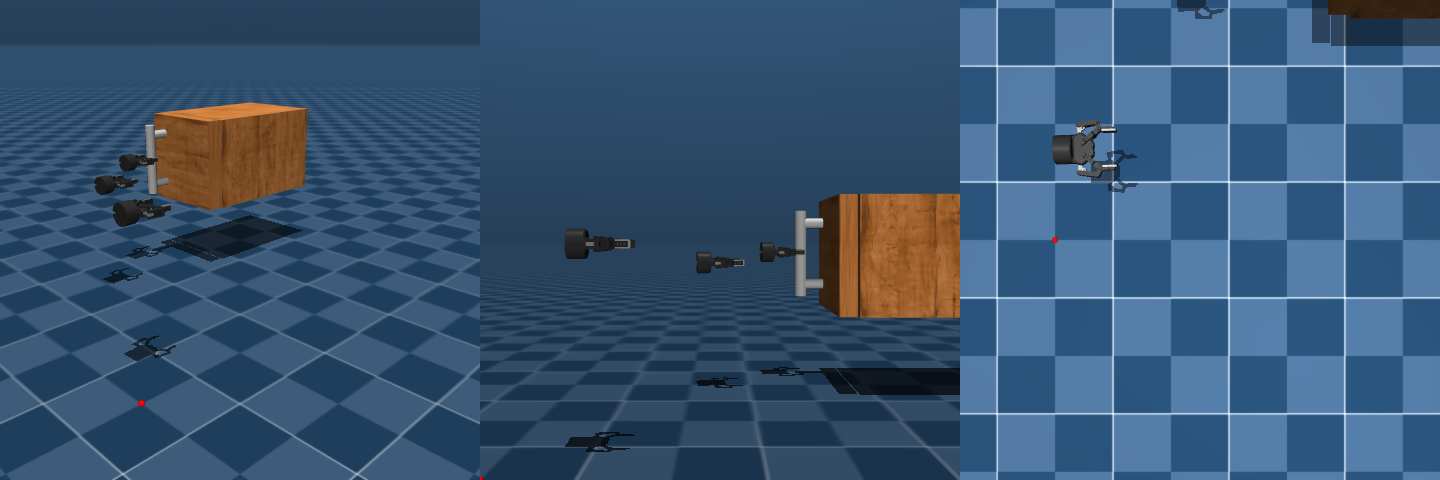

Trying mode: 1


""

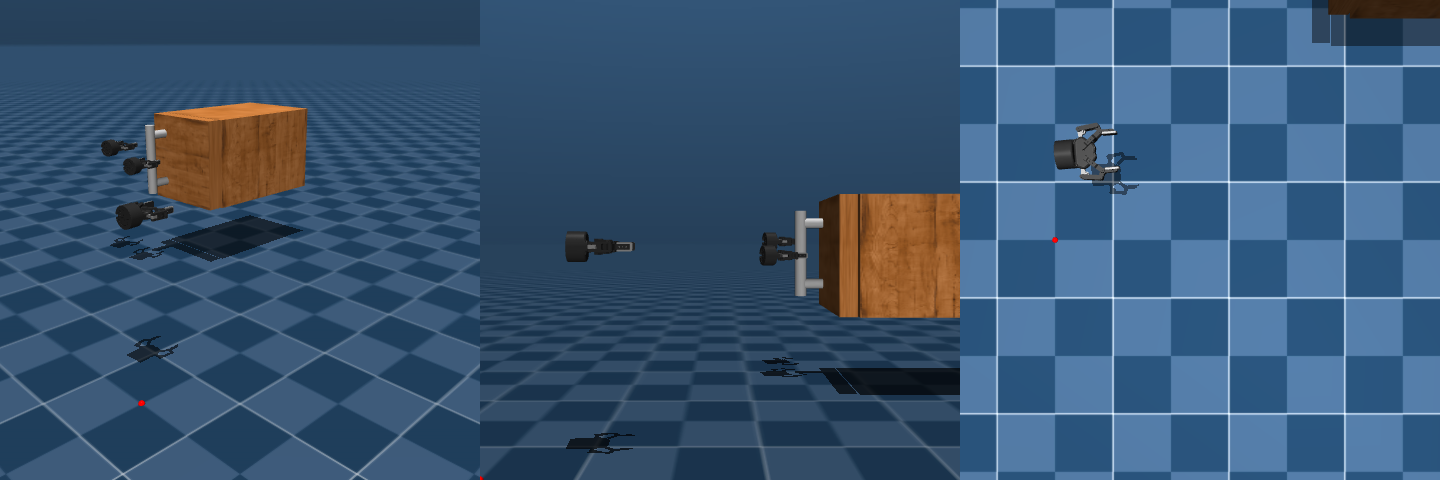

Trying mode: 3


""

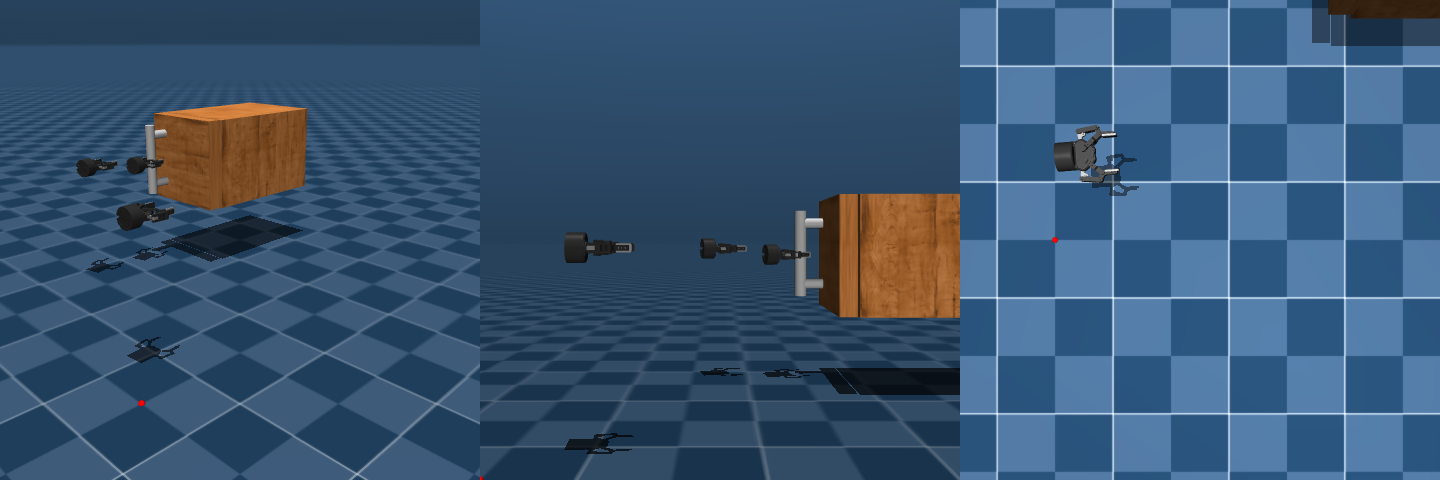

Trying mode: 1


In [12]:
label_idx = torch.randint(0, demos.x_des.shape[0], (1,)).item()
print("desired mode:", demos.slide_mode[label_idx])
label = torch.from_numpy(demos.x_des[label_idx]).to(cfg.device)
Avoid_samples = []
rmodel_aux, _, rdata_aux, _, _, _, _ = build_environment(cfg) 

rmodel_aux.body("cabinet").pos = demos.cabinet_pos[label_idx]
mujoco.mj_forward(rmodel_aux, rdata_aux)


for i in range(5):
    samples = sample_with_avoidance(uncond_model, state_model, avoidance_model, action_norm, state_norm, label, Avoid_samples, cfg, n_samples=1,guidance_avoid=1.0)
    key_frames = samples[0,:,:].cpu().numpy()
    img = visualize_key_frames(cfg, demos.cabinet_pos[label_idx], key_frames)
    media.show_image(img)
    Avoid_samples.append(samples.reshape([1,-1]))
    trying_mode = check_mode(rmodel_aux, rdata_aux, key_frames[-1,:])
    print("Trying mode:", trying_mode)

### Robot implementation

This section simulates closed-loop execution with replanning:

- A random cabinet pose and slide mode are sampled.
- A trajectory is generated with avoidance and executed via the low-level controller.
- The controller tracks the closest phase on the trajectory rather than resetting to the initial state.
- Failure is detected if progress stalls or the end-effector loses the handle after grasping.
- On failure, the system resamples with avoidance until success or a maximum number of attempts.


In [ ]:
from collections import deque
gripper_close = False
try:
    del renderer
except:
    pass

seed_val = torch.randint(1000000, (1,)).item()
torch.random.manual_seed(seed_val)

# Random test condition
Cabinet_loc = np.array([np.random.rand() + 0.8, np.random.rand(), np.random.rand() + 0.25])
slide_mode = np.random.choice([0,1,2,3]) # 0: push up, 1: pull, 2: slide right, 3: slide right


rmodel_aux, _, rdata_aux, _, _, _, _ = build_environment(cfg)  
rmodel, _, rdata, _, _, renderer, _ = build_environment(cfg)    

rmodel.body("cabinet").pos = Cabinet_loc
rmodel_aux.body("cabinet").pos = Cabinet_loc

rmodel = update_joint_model(rmodel, slide_mode)
rmodel_aux = update_joint_model(rmodel_aux, slide_mode)

mujoco.mj_forward(rmodel, rdata)
mujoco.mj_forward(rmodel_aux, rdata_aux)

x_des = rdata.geom("door_handle").xpos.copy()
label = torch.from_numpy(x_des).to(cfg.device) # Handle location

print("============================")
print("Cabinet Pos:", Cabinet_loc, " Desired mode mode:", slide_mode)
print("============================")

Avoid_samples = deque(maxlen=6)
samples = sample_with_avoidance(uncond_model, state_model, avoidance_model, action_norm, state_norm, label, Avoid_samples, cfg, n_samples=1,guidance_avoid=2.0/(i+1))
Avoid_samples.append(samples.reshape([1,-1]))
key_frames = samples[0,:,:].cpu().numpy()
# img = visualize_key_frames(cfg, demos.cabinet_pos[label_idx], key_frames)
# media.show_image(img)

trying_mode = check_mode(rmodel_aux, rdata_aux, key_frames[-1,:])
print("Trying mode:", trying_mode)


rmodel.opt.gravity[:] = np.array([0, 0, 0])  # No gravity
frames = []
key_frames_mod = key_frames
rdata.qpos[:4] = key_frames_mod[0,:]
mujoco.mj_forward(rmodel, rdata)


iter = 0
phase = 0
phase_track = deque(maxlen=20)
progress = 0
progress_track = deque(maxlen=20)
new_traj = True
iter_new = 0

while progress <0.5 and iter < 400:
    if iter >= iter_new + 10:
        new_traj = False
    rdata, phase = step_along_via_points(cfg, rmodel, rdata, key_frames_mod, 
                                                        0.2, #phase look ahead
                                                        400, #Kp
                                                        100, #kd
                                                        gripper_close, 
                                                        0.01,
                                                        new_traj = new_traj) #reaching the threshild
    phase_track.append(phase)
    progress = np.linalg.norm(x_des - rdata.geom("door_handle").xpos.copy())/0.25
    progress_track.append(progress)
    Failure = False
  
    ee_pos = (rdata.body("right_silicone_pad").xpos + rdata.body("left_silicone_pad").xpos) / 2
  
    ee_dist_des = np.linalg.norm(ee_pos - rdata.geom("door_handle").xpos.copy())
    if len(phase_track) == 20 and phase_track[0] == phase_track[-1] and progress_track[0] >= progress_track[-1]: # Failure detection
        print("\n=======================")
        print("Failure happened, trying resampling, trial number:", len(Avoid_samples)+1)
        Failure = True
    
    elif ee_dist_des > 0.1 and gripper_close == True:
        print("\n=======================")
        print("Failure happened, trying resampling, trial number:", len(Avoid_samples)+1)
        gripper_close = False
        new_traj = True
        iter_new = iter
        gripper_close = False
        Failure = True
    
    if Failure:
        samples = sample_with_avoidance(uncond_model, state_model, avoidance_model, action_norm, state_norm, label, Avoid_samples, cfg, n_samples=1,guidance_avoid=1.5)
        Avoid_samples.append(samples.reshape([1,-1]))
        if len(Avoid_samples) == 6:
            print("Total attempts was unsuccessful :(")
            break
        key_frames = samples[0,:,:].cpu().numpy()
        key_frames_mod = key_frames
        trying_mode = check_mode(rmodel_aux, rdata_aux, key_frames[-1,:])
        # img = visualize_key_frames(cfg, demos.cabinet_pos[label_idx], key_frames)
        # media.show_image(img)
        print("Trying mode:", trying_mode)
        print("========================")
        phase_track = deque(maxlen=20)

    render = True
    if ee_dist_des < 0.05 and gripper_close == False and iter > iter_new +5:
        gripper_close = True
        for i in range(10):
                rdata.ctrl[rmodel.nu - 1] = 255
                mujoco.mj_step(rmodel, rdata)
                mujoco.mj_forward(rmodel, rdata)
                renderer.update_scene(rdata, camera="closeup_xyz")
                frames.append(renderer.render())            
        render = False
    if render:
        renderer.update_scene(rdata, camera="closeup_xyz")
        frames.append(renderer.render())
    
    print(
        f"Current phase: {phase:.2f}, "
        f"gripper_status: {str(gripper_close):7s} "
        f"iteration: {iter:3d}",
        f"progress: {progress:.2f}",
        end="\r")
    iter += 1

media.show_video(images = frames, fps = cfg.framerate)

Cabinet Pos: [1.22937573 0.05125616 0.63389459]  Desired mode mode: 1
Trying mode: 2
Current phase: 0.84, gripper_status: True    iteration: 109 progress: 0.10
Failure happened, trying resampling, try number: 2
Trying mode: 3
Current phase: 0.44, gripper_status: True    iteration: 129 progress: 0.00
Failure happened, trying resampling, try number: 3
Trying mode: 1
